In this example we show how to create the Z2 ordered phase on a 1D chain of 11 atoms and how to perform a scan over the sweep time to understand the behavior of an adiabatic sweep and the effect of the Rydberg blockade on a many-body system.

In [2]:
from bloqade import save, load
from bloqade.atom_arrangement import Chain
import numpy as np
import os, time
import matplotlib.pyplot as plt

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [3]:
# Define relevant parameters for the lattice geometry and pulse schedule
n_atoms = 11
lattice_const = 6.1
min_time_step = 0.05

# Define Rabi amplitude and detuning values.
# Note the addition of a "sweep_time" variable
# for performing sweeps of time values.
rabi_amplitude_values = [0.0, 15.8, 15.8, 0.0]
rabi_detuning_values = [-16.33, -16.33, 16.33, 16.33]
durations = [0.8, "sweep_time", 0.8]

time_sweep_z2_prog = (
    Chain(n_atoms, lattice_const)
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values)
)

# Allow "sweep_time" to assume values from 0.05 to 2.4 microseconds for a total of
# 20 possible values.
# Starting at exactly 0.0 isn't feasible so we use the `min_time_step` defined
# previously.
time_sweep_z2_job = time_sweep_z2_prog.batch_assign(
    sweep_time=np.linspace(min_time_step, 2.4, 20)
)

In [4]:
# util func extracting Z2-pahse probability
def get_z2_probabilities(report):
    z2_probabilities = []
    for count in report.counts:
        z2_probability = count["01010101010"] / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

In [5]:
t0=time.time()
emu_batch = time_sweep_z2_job.braket.local_emulator().run(shots=1000)
print('run elaT=%.1f sec'%(time.time()-t0))

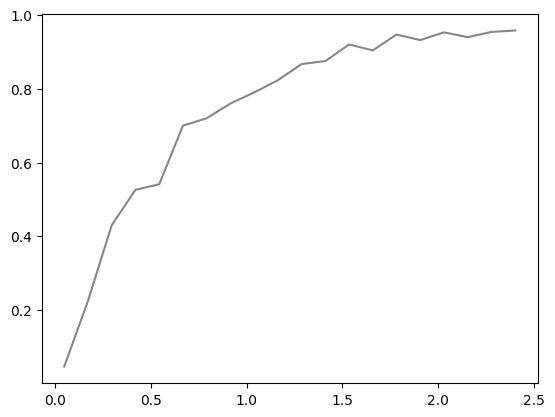

In [7]:
emu_report = emu_batch.report()
emu_probabilities = get_z2_probabilities(emu_report)
emu_sweep_times = emu_report.list_param("sweep_time")
plt.plot(emu_sweep_times, emu_probabilities, label="Emulator", color="#878787")

plt.show()

In [8]:
emu_report